In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import plotly
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import plotly.express as px
from pathlib import Path
import warnings

os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'
# import featuretools as ft

warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option('display.max_rows', 120)
plt.style.use("dark_background")
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams["hist.bins"] = 50
print('cur_dir', Path.cwd())

cur_dir /home/sergey/mnt/st1500/Usr/Sergey/TheJob/Otus/ML_advanced2020/final_project


In [32]:

"""
Задача оценки вероятности пролонгации депозитных сделок клиентов банка.
Описание:
Один из основных инструментов сбережения денежных средств является срочный банковский депозит.
По истечении срока, клиент может как забрать депозит, так и пролонгировать его,
открыв новую депозитную сделку.
Банку для управления портфелем средств клиентов важно понимать, с какой вероятностью клиент
оставит свои средства на новом депозите.
Вероятность пролонгации может зависеть от текущих условий сделок,
от изменения текущих условий сделки относительно предыдущих условий сделок этого клиента,
от характеристик самого клиента,
от поведения клиента по открытию депозитных сделок в прошлом,
а также от макроэкономической ситуации в момент заключения сделки.
Для банка рискованнее ошибочно считать, что пролонгация произойдет,
т.к. привлечь недостающие средства дороже, чем разместить избыточные.
Задача:
	Построить модель вероятности пролонгации депозитной сделки.

Описание данных:
В данных приводятся ID сделок и клиентов,
даты заключения и истечения срока действия депозита,
срок депозита, прочие условия депозитного договора,
характеристики и типы  клиентов.

Также можно предложить и добавить к данным характеристики макроэкономических условий
из открытых источников (Росстат, ЦБ РФ и прочие статистические ресурсы).

""";

In [3]:
data = pd .read_csv("/home/sergey/mnt/4.5Tb/Downloads/otus_final_input/data_encoded.csv", index_col='Client_Id', parse_dates=True)
print("", data.shape)
data.head()

/home/sergey/anaconda3/envs/final_project/lib/python3.8/site-packages/featuretools_update_checker/functions.py:34: UserWarning: Featuretools is out-of-date: installed == 0.23.1, latest == 0.23.2
  warnings.warn(msg)


 (274703, 10)


,DealDate,ValueDate,MaturityDate,Deal_characteristics_1,Deal_characteristics_2,Deal_characteristics_3,Deal_characteristics_4,Client_characteristics_1,Client_characteristics_2,target
Client_Id,,,,,,,,,,
14446,2019-12-17,2019-12-17,2019-12-24,0.061247,0.0400,0.085529,2,5,1654,0
2234,2020-01-27,2020-01-27,2020-02-25,0.030624,0.0368,0.063928,2,7,1196,0
2234,2019-10-30,2019-10-30,2019-12-02,0.019905,0.0402,0.063928,2,7,1196,1
2234,2019-11-29,2019-11-29,2019-12-06,0.030624,0.0398,0.063928,2,7,1196,1
2234,2019-12-27,2019-12-27,2020-01-13,0.061247,0.0369,0.063928,2,7,1196,1


In [4]:
dtypes = {
    'DealDate': np.datetime64,
    'ValueDate': np.datetime64,
    'MaturityDate': np.datetime64,
    'Deal_characteristics_1': np.float32,
    'Deal_characteristics_2': np.float32,
    'Deal_characteristics_3': np.float32,
    'Deal_characteristics_4': np.int32,
    'Client_characteristics_1': np.int32,
    'Client_characteristics_2': np.int32,
    'target': bool,
}

data = data.astype(dtypes)

dates = ['DealDate', 'ValueDate', 'MaturityDate']

In [5]:
for i, col1 in enumerate(dates):
    for col2 in dates[i+1:]:
        col1_is_bigger_df = data.loc[data[col1] > data[col2]]
        if len(col1_is_bigger_df) > 0:
            data.drop(labels=col1_is_bigger_df.index, inplace=True)
"""
Я выбросил одно значение, где 'DealDate' > 'ValueDate', полагаю, это опечатка, месяц указан неправильно
I dropped single value, where  'DealDate' > 'ValueDate'. Suppose this is typo, wrong month was typed
"""
data.insert(loc=0, value=(data.MaturityDate - data.DealDate).astype('timedelta64[D]'), column='DealDurationDays')
data.insert(loc=1, value=(data.DealDurationDays // 30).astype(int), column='DealDurationMonths')
print(data.shape)
data.head()

(274280, 12)


,DealDurationDays,DealDurationMonths,DealDate,ValueDate,MaturityDate,Deal_characteristics_1,Deal_characteristics_2,Deal_characteristics_3,Deal_characteristics_4,Client_characteristics_1,Client_characteristics_2,target
Client_Id,,,,,,,,,,,,
14446,7.0,0,2019-12-17,2019-12-17,2019-12-24,0.061247,0.0400,0.085529,2,5,1654,False
2234,29.0,0,2020-01-27,2020-01-27,2020-02-25,0.030624,0.0368,0.063928,2,7,1196,False
2234,33.0,1,2019-10-30,2019-10-30,2019-12-02,0.019905,0.0402,0.063928,2,7,1196,True
2234,7.0,0,2019-11-29,2019-11-29,2019-12-06,0.030624,0.0398,0.063928,2,7,1196,True
2234,17.0,0,2019-12-27,2019-12-27,2020-01-13,0.061247,0.0369,0.063928,2,7,1196,True


In [6]:
print(f" начальная DealDate дата в данных {data.DealDate.min().strftime('%Y-%m-%d')}\n",
      f" конечная  Maturity дата {data.MaturityDate.max().strftime('%Y-%m-%d')}\n",
      f" весь временной интервал в данных  дней {(data.MaturityDate.max() - data.DealDate.min()).days}\n")

 начальная DealDate дата в данных 2015-01-12
  конечная  Maturity дата 2020-06-29
  весь временной интервал в данных  дней 1995



In [7]:
print(f"всего записей {data.shape[0]}, из них уникальных клиентов {data.index.nunique()}")

всего записей 274280, из них уникальных клиентов 17521


In [8]:
client_id_activity = data.groupby(data.index).agg(['count', 'mean', 'median'])
client_id_activity.loc[client_id_activity['target']['count'] > 100]

DealDurationDays                   DealDurationMonths            \
                     count       mean median              count      mean   
Client_Id                                                                   
0                    16511  13.289988    7.0              16511  0.245533   
59                     121   7.148760    6.0                121  0.074380   
472                    172   9.029070    7.0                172  0.000000   
604                    118  19.991525   15.5                118  0.211864   
640                    466  28.512876   28.0                466  0.467811   
...                    ...        ...    ...                ...       ...   
24175                  202   2.183168    1.0                202  0.000000   
24264                  171   1.485380    1.0                171  0.000000   
24308                  239  36.351464   39.0                239  0.748954   
24335                  265   7.603774    3.0                265  0.045283   
24385                  129   1.403101    1.0                129  0.000000   

                 Deal_characteristics_1                      \
          median                  count      mean    median   
Client_Id                                                     
0            0.0                  16511  1.217816  0.313893   
59           0.0                    121  0.563905  0.306237   
472          0.0                    172  0.075452  0.033711   
604          0.0                    118  0.051134  0.022567   
640          0.0                    466  0.293246  0.189921   
...          ...                    ...       ...       ...   
24175        0.0                    202  2.984737  3.063171   
24264        0.0                    171  0.703659  0.566538   
24308        1.0                    239  0.047001  0.035217   
24335        0.0                    265  0.048791  0.021408   
24385        0.0                    129  5.730375  2.502210   

          Deal_characteristics_2  ... Deal_characteristics_4  \
                           count  ...                 median   
Client_Id                         ...                          
0                          16511  ...                    2.0   
59                           121  ...                    2.0   
472                          172  ...                    1.0   
604                          118  ...                    1.0   
640                          466  ...                    1.0   
...                          ...  ...                    ...   
24175                        202  ...                    2.0   
24264                        171  ...                    2.0   
24308                        239  ...                    2.0   
24335                        265  ...                    0.0   
24385                        129  ...                    1.0   

          Client_characteristics_1                   Client_characteristics_2  \
                             count       mean median                    count   
Client_Id                                                                       
0                            16511  10.497668   13.0                    16511   
59                             121   8.181818    4.0                      121   
472                            172  15.000000   15.0                      172   
604                            118  15.000000   15.0                      118   
640                            466  15.000000   15.0                      466   
...                            ...        ...    ...                      ...   
24175                          202  11.683168   15.0                      202   
24264                          171   9.888889   11.0                      171   
24308                          239  10.903766   15.0                      239   
24335                          265  11.769811   15.0                      265   
24385                          129  15.000000   15.0                      129   

                

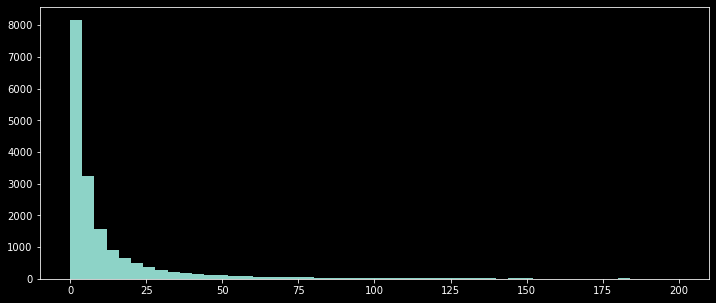

In [33]:
# client_id_activity_target.drop(labels=[0], inplace=True)
n, bins, patches = plt.hist(client_id_activity.loc[1:]['target']['count'], bins=50, range=(0, 200));
# plt.plot(bins[:10])

In [10]:
# client_id_activity_target.loc[client_id_activity_target['count'] > 200]['mean'].hist(bins=50)
# client_id_activity_target.loc[client_id_activity_target['count'] > 200]['median'].hist(bins=50)


## Все данные - гистограмма

In [11]:
def deal_duration_info(duration: pd.Series, label: str) -> None:
    """
        Графики и основные статистики, квантили для ряда с длиной сделки в днях
    :param duration: длина сделкм
    :param label: метка - строка в заголовок графика
    :return: None
    """
    print(label)
    print('mean', f"{duration.mean().astype(int)}")
    print('max', f"{duration.max().astype(int)}")
    print('min', f"{duration.min().astype(int)}")
    # quantiles
    for quantile in [20, 50, 70, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]:
        ndays = np.percentile(duration.values, quantile).astype(int)
        print(f'{quantile}% {ndays} days {ndays // 30} months')

    print(f"std {duration.values.astype('int64').std().astype(int)}")
    print('nuniques', duration.nunique())

    # fig = plt.figure(figsize=(15, 8))
    plt.hist(x=duration, bins=150, label=label)
    plt.title(label)
    plt.xlabel("days")
    plt.ylabel('frequency')
    plt.legend()
    plt.grid()
    plt.show()
    # fig = px.histogram(duration, title=duration.name, nbins=10)
    # fig.show()

all quantiles
mean 12
max 1461
min 1
20% 1 days 0 months
50% 7 days 0 months
70% 10 days 0 months
90% 31 days 1 months
91% 31 days 1 months
92% 32 days 1 months
93% 33 days 1 months
94% 34 days 1 months
95% 38 days 1 months
96% 48 days 1 months
97% 62 days 2 months
98% 89 days 2 months
99% 98 days 3 months
std 27
nuniques 391


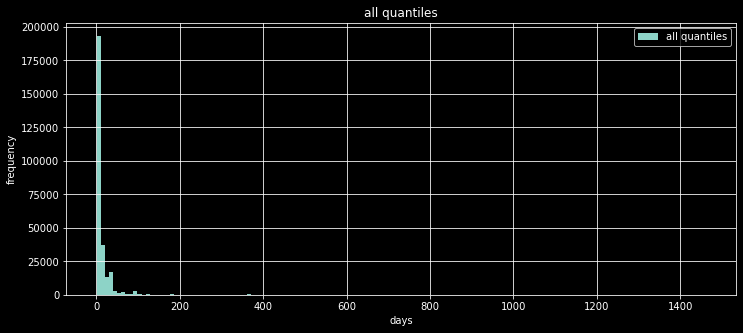

In [12]:
deal_duration_info(data.DealDurationDays, label="all quantiles")

#### 90% клиентов держат деньги не больше месяца, т.е. к следующей зарплате ничего на счету не остается,
    


## посмотрим на квантиль 90% - 100%

quantile 90% - 100%
mean 69
max 1461
min 32
20% 33 days 1 months
50% 45 days 1 months
70% 68 days 2 months
90% 112 days 3 months
91% 121 days 4 months
92% 130 days 4 months
93% 151 days 5 months
94% 177 days 5 months
95% 183 days 6 months
96% 187 days 6 months
97% 241 days 8 months
98% 364 days 12 months
99% 366 days 12 months
std 69
nuniques 360


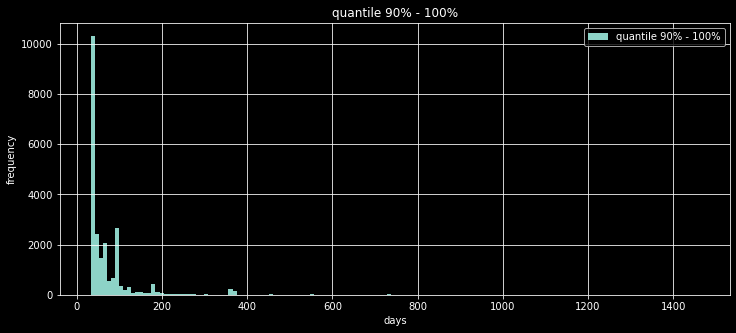

In [13]:
duration90_100 = data.DealDurationDays[data.DealDurationDays > 31]
deal_duration_info(duration90_100, label="quantile 90% - 100%")

## выбросы мешают, посмотрим, как выглядит интерквантиль 90% - 99%

quantile 90%-99%
mean 50
max 97
min 32
20% 33 days 1 months
50% 41 days 1 months
70% 60 days 2 months
90% 91 days 3 months
91% 91 days 3 months
92% 91 days 3 months
93% 91 days 3 months
94% 92 days 3 months
95% 92 days 3 months
96% 92 days 3 months
97% 93 days 3 months
98% 94 days 3 months
99% 95 days 3 months
std 21
nuniques 66


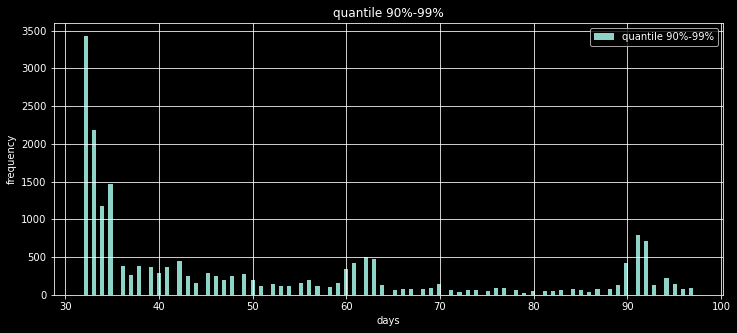

In [14]:
duration90_99 = data.DealDurationDays[(data.DealDurationDays > np.quantile(data.DealDurationDays.values,  .90))
                                  & (data.DealDurationDays < np.quantile(data.DealDurationDays.values,  .99))]
deal_duration_info(duration90_99, label="quantile 90%-99%")

#### 90-99% интерквартиль держат деньги на депозите от 1 до 3 месяцев

duration_year_plus
mean 468
max 1461
min 366
20% 366 days 12 months
50% 368 days 12 months
70% 459 days 15 months
90% 732 days 24 months
91% 732 days 24 months
92% 732 days 24 months
93% 732 days 24 months
94% 733 days 24 months
95% 760 days 25 months
96% 1094 days 36 months
97% 1096 days 36 months
98% 1096 days 36 months
99% 1098 days 36 months
std 189
nuniques 65


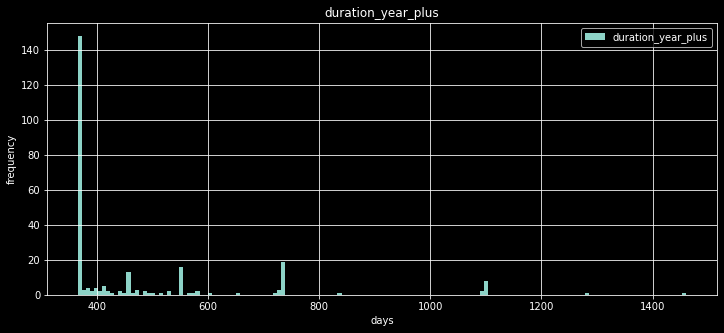

In [15]:
duration_year_plus = data.DealDurationDays[(data.DealDurationDays > 365)]
deal_duration_info(duration_year_plus, label="duration_year_plus")

#### В основном после года депозит забирают

In [16]:
value_counts = data.target.value_counts()
print('Дисбаланс классов')
print(value_counts)
print(value_counts[1]/value_counts[0])


Дисбаланс классов
True     183767
False     90513
Name: target, dtype: int64
2.0302829427817


In [17]:
print(data.shape)
print(data.columns)

(274280, 12)
Index(['DealDurationDays', 'DealDurationMonths', 'DealDate', 'ValueDate',
       'MaturityDate', 'Deal_characteristics_1', 'Deal_characteristics_2',
       'Deal_characteristics_3', 'Deal_characteristics_4',
       'Client_characteristics_1', 'Client_characteristics_2', 'target'],
      dtype='object')


In [18]:
float_deal_characteristics = ['Deal_characteristics_1', 'Deal_characteristics_2',
       'Deal_characteristics_3']

def float_deal_char_info(deal_characteristic: pd.Series, label: str):
    print(label)
    print("nunique", deal_characteristic.nunique())


In [19]:
float_deal_char_info(data.Deal_characteristics_1, label="Deal_characteristics_1")

Deal_characteristics_1
nunique 41665


In [20]:
float_deal_char_info(data.Deal_characteristics_2, label="Deal_characteristics_2")

Deal_characteristics_2
nunique 1245


In [21]:
float_deal_char_info(data.Deal_characteristics_3, label="Deal_characteristics_3")

Deal_characteristics_3
nunique 21999


In [22]:
print(data.Deal_characteristics_4.unique())

group4 = data.groupby(by='Deal_characteristics_4')

[2 0 1]


In [23]:
print('group4.mean()')
group4.mean()

group4.mean()


,DealDurationDays,DealDurationMonths,Deal_characteristics_1,Deal_characteristics_2,Deal_characteristics_3,Client_characteristics_1,Client_characteristics_2,target
Deal_characteristics_4,,,,,,,,
0,16.744210,0.356370,0.976521,0.061779,0.085586,12.384288,1488.732714,0.682207
1,13.882973,0.183904,0.968889,0.058384,0.086138,14.986631,1753.665048,0.668440
2,11.815681,0.184809,0.976608,0.057520,0.083676,11.583282,1427.568350,0.668517


In [24]:
print('group4.median()')
group4.median()

group4.median()


,DealDurationDays,DealDurationMonths,Deal_characteristics_1,Deal_characteristics_2,Deal_characteristics_3,Client_characteristics_1,Client_characteristics_2,target
Deal_characteristics_4,,,,,,,,
0,4.0,0,0.149856,0.0559,0.083749,15,1759,True
1,7.0,0,0.210812,0.0536,0.086089,15,1759,True
2,7.0,0,0.306237,0.0532,0.081038,15,1759,True


In [25]:
print('group4.std()')
group4.std()

group4.std()


,DealDurationDays,DealDurationMonths,Deal_characteristics_1,Deal_characteristics_2,Deal_characteristics_3,Client_characteristics_1,Client_characteristics_2,target
Deal_characteristics_4,,,,,,,,
0,48.505187,1.583508,4.280479,0.022964,0.019573,4.908261,534.539080,0.465626
1,22.017365,0.701831,3.205136,0.017522,0.011843,0.279835,78.106146,0.470782
2,23.634502,0.760843,3.732960,0.017907,0.016374,4.788308,516.095169,0.470747


count    274280.000000
mean         12.043536
std           4.655866
min           0.000000
25%           9.000000
50%          15.000000
75%          15.000000
max          15.000000
Name: Client_characteristics_1, dtype: float64

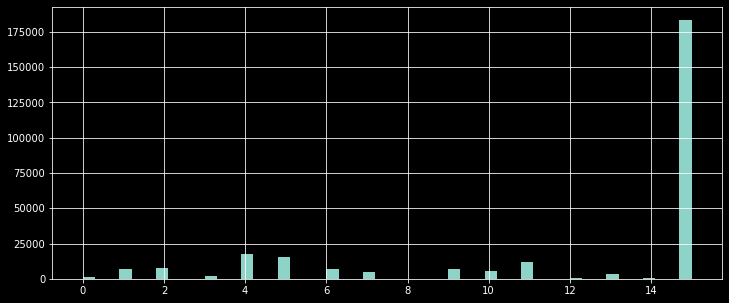

In [26]:
data.Client_characteristics_1.hist(bins=50)
data.Client_characteristics_1.describe()

count    274280.000000
mean       1469.972787
std         500.195826
min           0.000000
25%        1299.000000
50%        1759.000000
75%        1759.000000
max        1759.000000
Name: Client_characteristics_2, dtype: float64

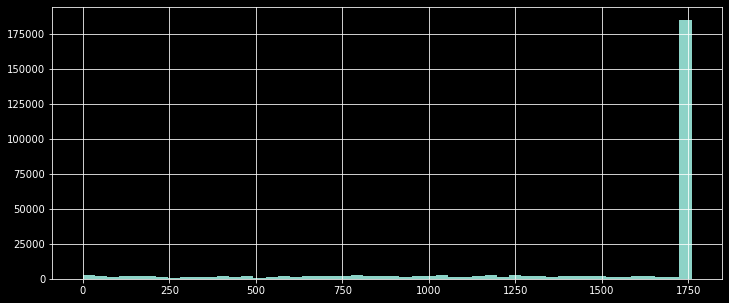

In [27]:
data.Client_characteristics_2.hist(bins=50, figsize=(12, 5))
data.Client_characteristics_2.describe()


In [28]:
# import seaborn as sns
# plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
# sns.set(style="darkgrid", context="talk")

nodates = [col for col in data.columns if col not in dates ]
# for i, col1 in enumerate(nodates):
#     for col2 in nodates[i+1:]:
#         fig = plt.figure(figsize=(5,3))
#         plt.title(f'{col1} : {col2}')
#         plt.xlabel(col1)
#         plt.ylabel(col2)
#         plt.scatter(x=data[col1], y=data[col2])
        # sns.scatterplot(x=data[col1], y=data[col2]);

In [29]:
data.columns

Index(['DealDurationDays', 'DealDurationMonths', 'DealDate', 'ValueDate',
       'MaturityDate', 'Deal_characteristics_1', 'Deal_characteristics_2',
       'Deal_characteristics_3', 'Deal_characteristics_4',
       'Client_characteristics_1', 'Client_characteristics_2', 'target'],
      dtype='object')

In [30]:
maturity_count = data.MaturityDate.value_counts()
deal_count = data.DealDate.value_counts()
maturity_count

2020-01-09    1278
2019-01-09    1202
2018-01-09    1188
2017-01-09    1061
2016-01-11     806
              ... 
2019-05-10       2
2020-05-11       2
2017-12-24       1
2018-08-04       1
2020-05-05       1
Name: MaturityDate, Length: 1358, dtype: int64

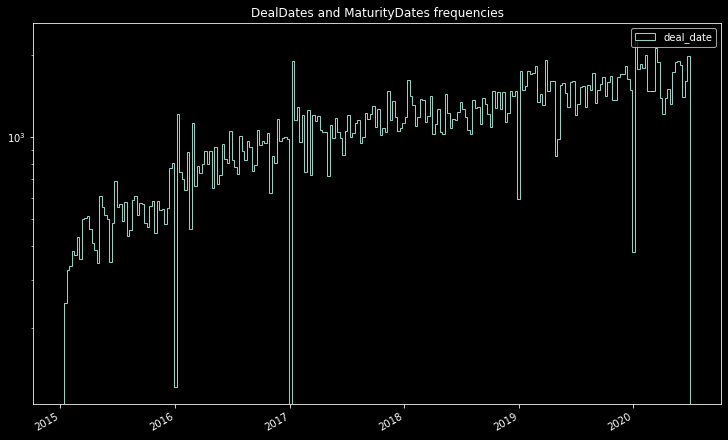

In [34]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True);
# matutity_hist_values = plt.hist(maturity_count, bins=50, label='maturity')
# deal_hist_values = plt.hist(deal_count, bins=50)

# matutity_hist_values = ax.hist(maturity_count, bins=50, label='maturity')
# deal_hist_values = plt.hist(deal_count, bins=50, label='deal_date')

# ax.hist(data.DealDate, label='maturity', histtype='step', bins=250)
maturity_ax = ax.hist(data.MaturityDate, label='deal_date', histtype='step', bins=250, log=True)
# print(maturity_ax)
# ax.barh(importances_np[1], importances_np[0], align='center');
plt.legend()
plt.title('DealDates and MaturityDates frequencies')
plt.setp(ax.get_xticklabels(), rotation=30, ha="right");